# Predicting GC-like phenotype and Naive/Memory separation in B cells within the general manifold

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
# need to do 'pip3 install bbknn==1.3.8' to avoid incompatibility errors
import bbknn
# requires 'pip install scrublet'
#import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
%%bash

pip freeze

aiohttp==3.6.2
alembic==1.3.0
anndata==0.7.5
annoy==1.16.2
async-generator==1.10
async-timeout==3.0.1
attrs==19.3.0
backcall==0.1.0
bbknn==1.3.6
bleach==3.1.0
blinker==1.4
certifi==2019.9.11
certipy==0.1.3
cffi==1.13.2
chardet==3.0.4
Click==7.0
conda==4.7.12
conda-package-handling==1.6.0
cryptography==2.8
cycler==0.10.0
Cython==0.29.14
decorator==4.4.1
defusedxml==0.6.0
entrypoints==0.3
fbpca==1.0
geosketch==1.0
get-version==2.1
h5py==2.10.0
idna==2.8
importlib-metadata==0.23
intervaltree==2.1.0
ipykernel==5.1.3
ipython==7.9.0
ipython-genutils==0.2.0
jedi==0.15.1
Jinja2==2.10.3
joblib==0.14.0
json5==0.8.5
jsonschema==3.1.1
jupyter-client==5.3.3
jupyter-core==4.5.0
jupyter-rsession-proxy==1.0b6
jupyter-server-proxy==1.2.0
jupyterhub==1.0.0
jupyterlab==1.2.1
jupyterlab-server==1.0.6
kiwisolver==1.1.0
legacy-api-wrap==1.2
leidenalg==0.7.0
llvmlite==0.30.0
loompy==3.0.6
louvain==0.6.1
Mako==1.1.0
MarkupSafe==1.1.1
matplotlib==3.3.3
mistune==0.8.4
more-itertools==7.2.0
multidict==4.5.2
nats

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
annoy               NA
attr                19.3.0
backcall            0.1.0
bbknn               NA
cffi                1.13.2
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.1
get_version         2.1
h5py                2.10.0
highs_wrapper       NA
igraph              0.7.1
importlib_metadata  0.23
ipykernel           5.1.3
ipython_genutils    0.2.0
jedi                0.15.1
joblib              0.14.0
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.7.0
llvmlite            0.30.0
louvain             0.6.1
matplotlib          3.3.3
more_itertools      NA
mpl_toolkits        NA
natsort             6.2.0
numba               0.46.0
numexpr             2.7.0
numpy               1.17.4
packaging           19.2
pandas              0.25.3
parso               0.5.1
pexpect        

In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/'

## Reading the fully analysed transcriptomics dataset (all cells manifold)

In [6]:
# normalised, log tr and scaled values in .X, HVG-subsetted
# normalised and log tr in .raw.X, all genes
adata_hvg = sc.read(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs_GEX_and_SoupX_denoised_protein_all_samples_cleaned_up_final_20210111.h5ad')

In [7]:
# getting final annotation
annot_table = pd.read_csv(save_path + 'annotation_of_adata_hvg_BBKNN_GEX_and_SoupX_denoised_protein_all_samples_20210108.csv',
                         index_col=0)
annot_table

,cell_type_final
AAACCTGAGAATGTGT-1,Monocytes_CD16+
AAACCTGAGACTAAGT-1,cDC2
AAACCTGAGCCGCCTA-1,TCM_CD8+
AAACCTGAGCGCCTCA-1,TEM_CD8+
AAACCTGAGGATGTAT-1,TEM_CD8+
...,...
TTTGTCATCGCCTGAG-1,doublets_by_TCR
TTTGTCATCGTCACGG-1-1,Monocytes_Classical
TTTGTCATCGTCTGCT-1-1,iNKT_cells
TTTGTCATCTACTTAC-1,doublets


In [8]:
adata_hvg.obs['cell_type_final'] = annot_table.loc[adata_hvg.obs_names, 'cell_type_final']
np.unique(adata_hvg.obs['cell_type_final'])

array(['B_cells_memory', 'B_cells_naive', 'MAIT_cells', 'Macrophages',
       'Monocytes_CD16+', 'Monocytes_Classical', 'NK_CD16_bright',
       'NK_CD56_bright', 'Plasma_cells', 'Precursor_Cells', 'TCM_CD8+',
       'TEM_CD8+', 'TMRA_CD8+', 'T_cells_CD4+_activated',
       'T_cells_CD4+_memory', 'T_cells_CD4+_naive',
       'T_cells_CD8+_activated', 'T_cells_CD8+_naive', 'cDC1', 'cDC2',
       'gdT_cells', 'iNKT_cells', 'pDCs'], dtype=object)

# 1. Predicting GC-like phenotype from the Milpied et. al. dataset

In [72]:
adata_GC_hvg = sc.read('/lustre/scratch117/cellgen/team292/aa22/adata_objects/CVID/202003_first_submission/adata_Milpied_GC_processed.h5ad')

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [73]:
# if using all genes
adata_GC_hvg_full = anndata.AnnData(X = adata_GC_hvg.raw.X,
                              obs = adata_GC_hvg.obs,
                              var = adata_GC_hvg.raw.var,
                              obsm = adata_GC_hvg.obsm,
                              varm = adata_GC_hvg.raw.varm)
# scaling
sc.pp.scale(adata_GC_hvg_full, max_value=10)

In [74]:
adata_hvg_B_cells = adata_hvg[adata_hvg.obs['cell_type_final'].isin(['B_cells_memory', 'B_cells_naive', 'Plasma_cells'])].copy()

In [75]:
adata_B_full = anndata.AnnData(X = adata_hvg_B_cells.raw.X,
                              obs = adata_hvg_B_cells.obs,
                              var = adata_hvg_B_cells.raw.var,
                              obsm = adata_hvg_B_cells.obsm,
                              varm = adata_hvg_B_cells.raw.varm)

# scaling
sc.pp.scale(adata_B_full, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


# Annotation - through GC B-cell data from [Milpied et al., Nature Immunology, 2018](https://www.nature.com/articles/s41590-018-0181-4#rightslink)

In [76]:
# full (all genes) versions of the annotated object and test object
# here both the datasets are normalised, log transformed and scaled
adata_train = adata_GC_hvg_full.copy()

adata_test = adata_B_full.copy()

In [77]:
adata_test

AnnData object with n_obs × n_vars = 14862 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'f

### Subsetting both datasets' copies to common genes only

I will train logreg on the subsetted data and tranfer the annotation onto the corresponding subsetted new data and then transfer that onto the full (with all genes) new dataset

In [78]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between previous training and test data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

13731 genes are shared between previous training and test data 
 14157 genes in training data 
 22144 genes in test joint data 



In [79]:
adata_train.var_names

Index(['FO538757.2', 'AP006222.2', 'RP11-206L10.9', 'LINC00115', 'FAM41C',
       'RP11-54O7.1', 'NOC2L', 'RP11-54O7.17', 'HES4', 'ISG15',
       ...
       'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'BX004987.4', 'AC145212.2',
       'AL592183.1', 'AL354822.1', 'AC004556.1', 'AC240274.1'],
      dtype='object', name='index', length=14157)

Going to copy a joint dataset with only common genes, but then transfer annotation from logreg onto the full dataset

In [80]:
adata_train_copy = adata_train[:,common_genes]

In [81]:
adata_train_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M-AS1', 'A2ML1', 'A4GALT', 'AAAS', 'AACS',
       'AAED1', 'AAGAB', 'AAK1',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'bP-21264C1.2'],
      dtype='object', name='index', length=13731)

In [82]:
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M-AS1', 'A2ML1', 'A4GALT', 'AAAS', 'AACS',
       'AAED1', 'AAGAB', 'AAK1',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'bP-21264C1.2'],
      dtype='object', length=13731)

In [83]:
# checking gene correspondence!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [84]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 859 × 13731
    obs: 'cell_id', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'louvain', 'cell_type'
    var: 'n_cells', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

In [85]:
np.unique(adata_train_copy.obs['cell_type'],return_counts=True)

(array(['GC_B_cells', 'Other_B_cells'], dtype=object), array([358, 501]))

# Training a logistic regression model on previously annotated SS2 data

In [86]:
adata_train_copy.obs['cell_type'].head()

index
0    Other_B_cells
1       GC_B_cells
2    Other_B_cells
3    Other_B_cells
4    Other_B_cells
Name: cell_type, dtype: category
Categories (2, object): [GC_B_cells, Other_B_cells]

In [87]:
celltypes_train = adata_train_copy.obs['cell_type']

In [88]:
adata_train_copy.X.shape

(859, 13731)

Using ONLY COMMON GENES

In [89]:
%%time
# training a logistic regression model
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(adata_train_copy.X, celltypes_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 8.14 s, sys: 20.1 s, total: 28.2 s
Wall time: 2.51 s


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [90]:
# already done
# Saving model based on all genes
pkl_filename = "logreg_GC_all_genes_20210113.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr, file)

In [115]:
# already done
# Saving model based on all genes
pkl_filename = "logreg_GC_hvgs_only_20210113.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr, file)

In [91]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 859 × 13731
    obs: 'cell_id', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'louvain', 'cell_type'
    var: 'n_cells', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

In [92]:
adata_test_copy

View of AnnData object with n_obs × n_vars = 14862 × 13731
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_id

In [93]:
logisticRegr

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [94]:
%%time
predictions = logisticRegr.predict(adata_test_copy.X)
adata_test_copy.obs['GC_celltype_predictions_all_genes'] = predictions

Trying to set attribute `.obs` of view, copying.


CPU times: user 10.9 s, sys: 6.21 s, total: 17.1 s
Wall time: 14.7 s


In [95]:
%%time
# probabilities
probabilities = logisticRegr.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['GC_celltype_predictions_all_genes']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])


CPU times: user 1.1 s, sys: 3.01 s, total: 4.11 s
Wall time: 2.11 s


In [96]:
# need to only assign predictions and probabilities to B cell clusters
list(adata_test_copy.obs.index) == list(adata_hvg.obs.index)

False

In [97]:
adata_test_copy.obs['probabilities_GC_all_genes'] = probs_adata

In [108]:
def add_predictions_and_probs(barcode, 
                              col # either GC_celltype_predictions_all_genes or probabilities_GC_all_genes
                             ):
    
    barcode_is_B_cell = barcode in adata_test_copy.obs_names
    
    if barcode_is_B_cell:
        value = adata_test_copy.obs.loc[barcode, col]
        return(value)
    else:
        if col == 'probabilities_GC_all_genes':
            return(0)
        elif col == 'GC_celltype_predictions_all_genes':
            return('NA')
        

In [109]:
adata_hvg.obs['barcode'] = adata_hvg.obs.index

In [110]:
for column in ['GC_celltype_predictions_all_genes','probabilities_GC_all_genes']:
    print(column)
    adata_hvg.obs[column] = adata_hvg.obs['barcode'].apply(lambda x: add_predictions_and_probs(x, column))

GC_celltype_predictions_all_genes
probabilities_GC_all_genes


... storing 'GC_celltype_predictions_all_genes' as categorical


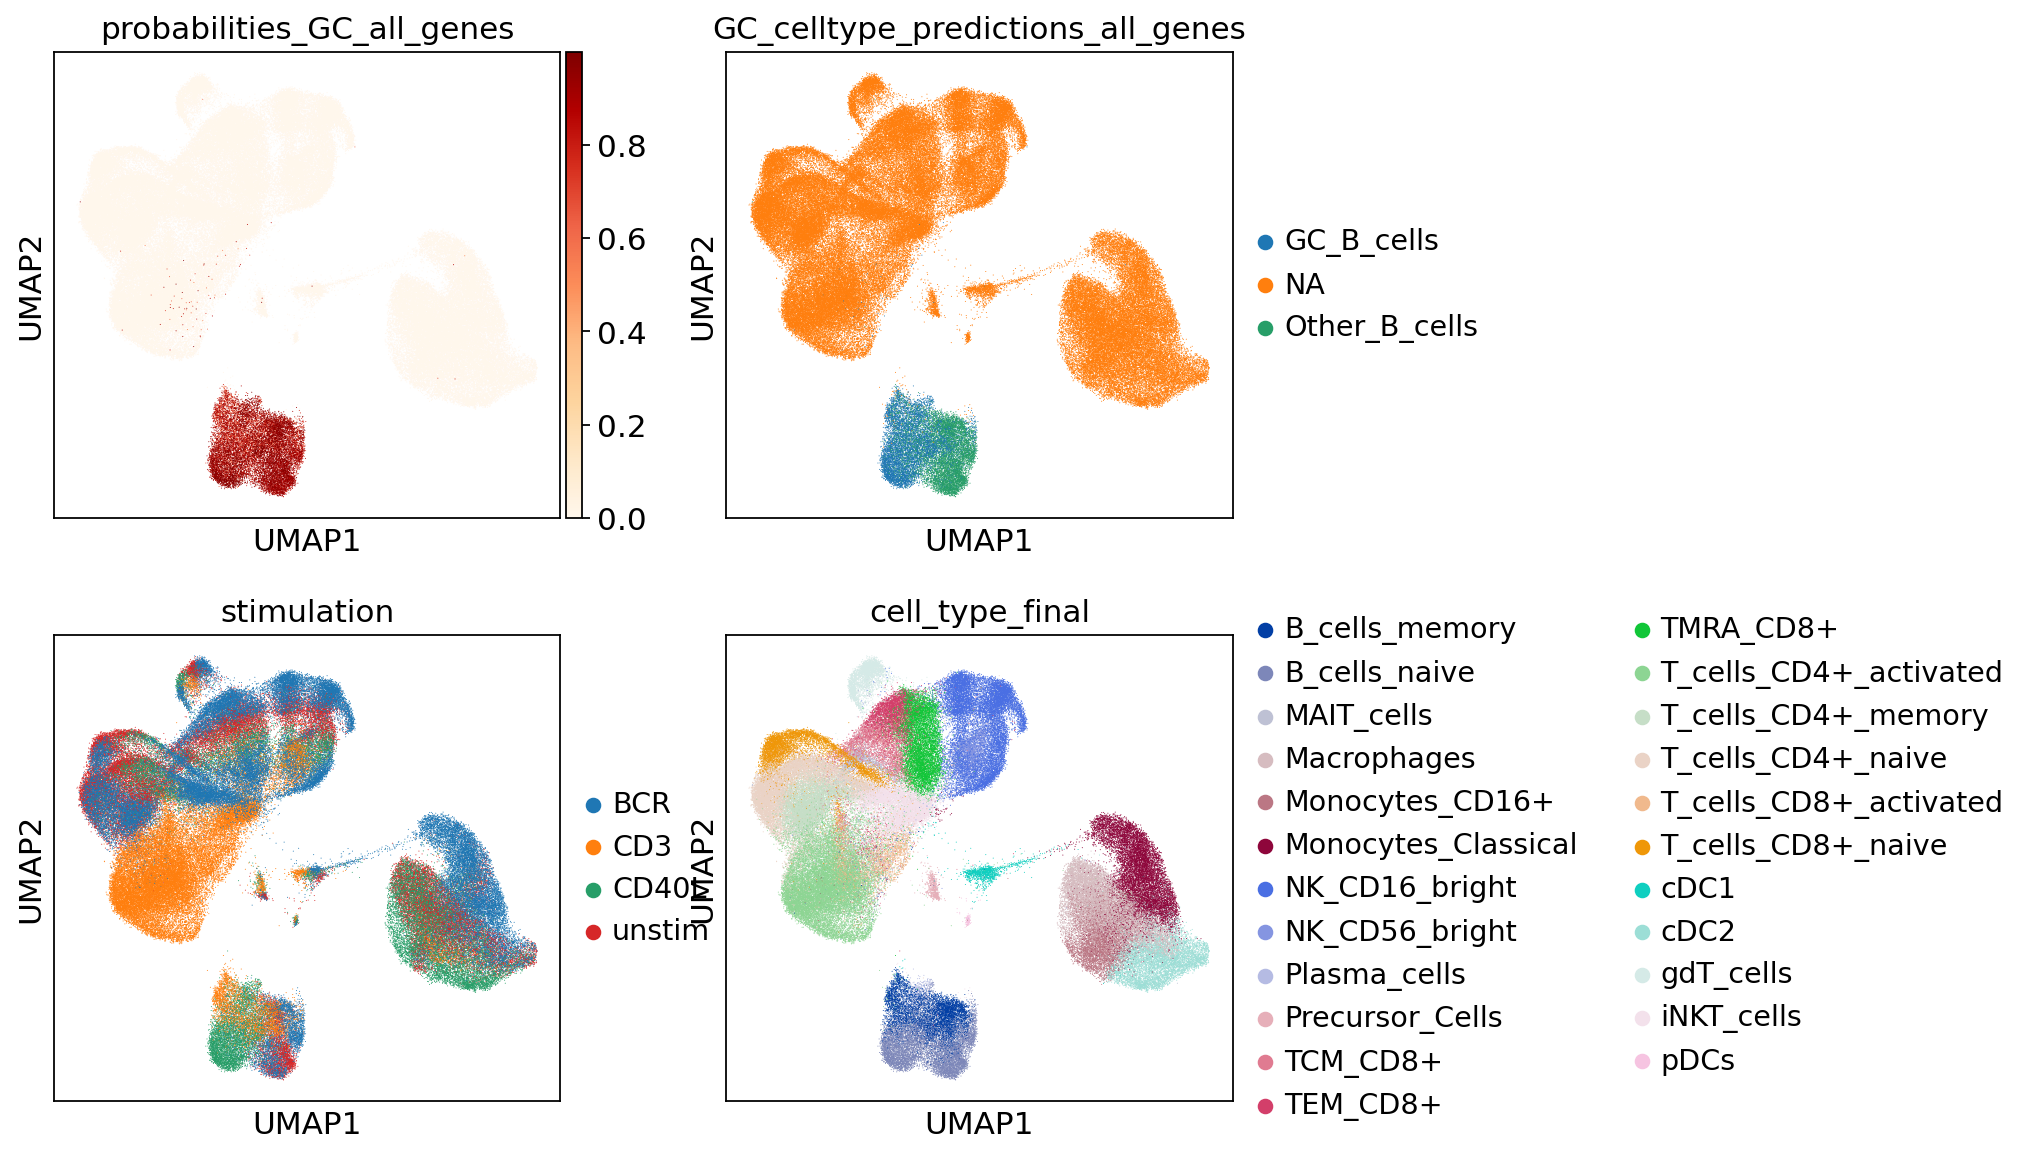

In [111]:
sc.pl.umap(adata_hvg, color = [#'probabilities_GC_hvgs', 'GC_celltype_predictions_hvgs',
                               'probabilities_GC_all_genes', 'GC_celltype_predictions_all_genes',
                              'stimulation', 'cell_type_final'],
           ncols=2,
           cmap='OrRd')

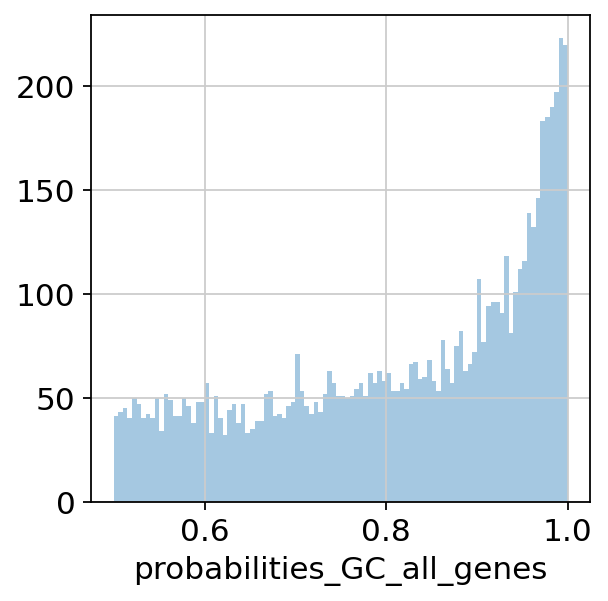

In [114]:
p3 = sns.distplot(adata_hvg[adata_hvg.obs['GC_celltype_predictions_all_genes'] == 'GC_B_cells'].obs['probabilities_GC_all_genes'], 
                  bins=100, kde=False)
plt.show()

In [115]:
np.median(adata_hvg[adata_hvg.obs['GC_celltype_predictions_all_genes'] == 'GC_B_cells'].obs['probabilities_GC_all_genes'])

0.8483447424650554

In [116]:
table_predictions = adata_hvg.obs.loc[:, ['GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes']]

In [117]:
table_predictions.head()

,GC_celltype_predictions_all_genes,probabilities_GC_all_genes
AAACCTGAGAATGTGT-1,NA,0.0
AAACCTGAGACTAAGT-1,NA,0.0
AAACCTGAGCCGCCTA-1,NA,0.0
AAACCTGAGCGCCTCA-1,NA,0.0
AAACCTGAGGATGTAT-1,NA,0.0


In [118]:
table_predictions.shape

(145823, 2)

In [119]:
table_predictions.to_csv(save_path + 'table_predictions_GC_B_cells_GEX_and_SoupX_denoised_protein_all_samples_20210113.csv')

# 2. Predicting Naive/Memory B cells from (a) old SS2 data

In [123]:
adata_SS2_hvg = sc.read('/home/jovyan/notebooks/Vento_Lab/CVID/GitHub_to_post/CVID_old_full/scTranscriptomics/adata_SS2_corrected.h5ad')

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [125]:
adata_SS2_hvg

AnnData object with n_obs × n_vars = 1324 × 6228
    obs: 'batch', 'batchcode', 'bh_pval', 'celltype', 'lane', 'n_counts', 'n_genes', 'percent_mito', 'scrublet_cluster_score', 'scrublet_score', 'treatment', 'is_doublet', 'louvain', 'is_doublet_poptrim', 'cell_id'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

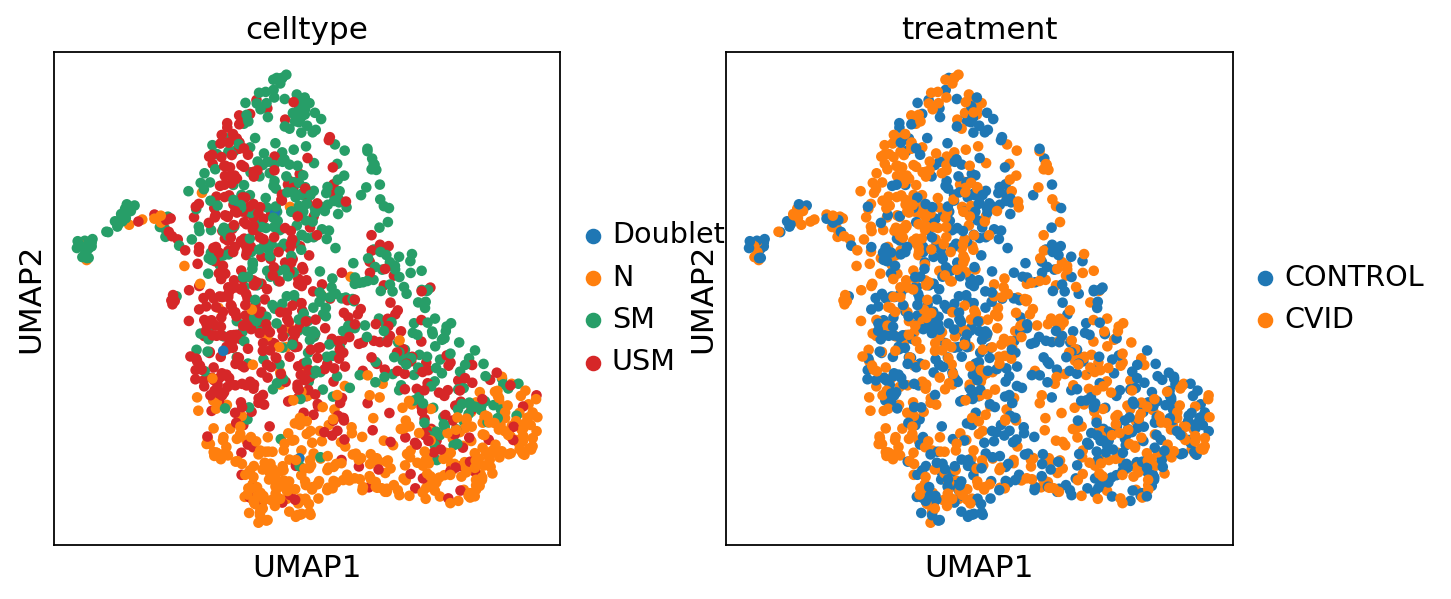

In [126]:
sc.pl.umap(adata_SS2_hvg, color=['celltype','treatment'])

In [127]:
# if using all genes
adata_SS2_hvg_full = anndata.AnnData(X = adata_SS2_hvg.raw.X,
                              obs = adata_SS2_hvg.obs,
                              var = adata_SS2_hvg.raw.var,
                              obsm = adata_SS2_hvg.obsm,
                              varm = adata_SS2_hvg.raw.varm)
# scaling
sc.pp.scale(adata_SS2_hvg_full, max_value=10)

In [128]:
adata_hvg_B_cells = adata_hvg[adata_hvg.obs['cell_type_final'].isin(['B_cells_memory', 'B_cells_naive', 'Plasma_cells'])].copy()

In [129]:
adata_B_full = anndata.AnnData(X = adata_hvg_B_cells.raw.X,
                              obs = adata_hvg_B_cells.obs,
                              var = adata_hvg_B_cells.raw.var,
                              obsm = adata_hvg_B_cells.obsm,
                              varm = adata_hvg_B_cells.raw.varm)

# scaling
sc.pp.scale(adata_B_full, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [130]:
# full (all genes) versions of the annotated object and test object
# here both the datasets are normalised, log transformed and scaled
adata_train = adata_SS2_hvg_full.copy()

adata_test = adata_B_full.copy()

In [131]:
adata_test

AnnData object with n_obs × n_vars = 14862 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'barcode', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-

### Subsetting both datasets' copies to common genes only

I will train logreg on the subsetted data and tranfer the annotation onto the corresponding subsetted new data and then transfer that onto the full (with all genes) new dataset

In [132]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between previous training and test data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

17601 genes are shared between previous training and test data 
 21030 genes in training data 
 22144 genes in test joint data 



In [133]:
adata_train.var_names

Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'RP11-108M9.2', 'RP11-116D17.3', 'IL12B', 'ATP11A-AS1', 'REEP1',
       'RP11-191L9.4', 'ZNF695', 'C16orf47', 'CYSLTR2', 'POU5F1B'],
      dtype='object', name='index', length=21030)

Going to copy a joint dataset with only common genes, but then transfer annotation from logreg onto the full dataset

In [134]:
adata_train_copy = adata_train[:,common_genes]

In [135]:
adata_train_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS', 'AACS',
       'AADAT', 'AAED1',
       ...
       'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3',
       'bP-21264C1.2', 'bP-2189O9.3'],
      dtype='object', name='index', length=17601)

In [136]:
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS', 'AACS',
       'AADAT', 'AAED1',
       ...
       'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3',
       'bP-21264C1.2', 'bP-2189O9.3'],
      dtype='object', length=17601)

In [137]:
# checking gene correspondence!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [138]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 1324 × 17601
    obs: 'batch', 'batchcode', 'bh_pval', 'celltype', 'lane', 'n_counts', 'n_genes', 'percent_mito', 'scrublet_cluster_score', 'scrublet_score', 'treatment', 'is_doublet', 'louvain', 'is_doublet_poptrim', 'cell_id'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

In [140]:
np.unique(adata_train_copy.obs['celltype'],return_counts=True)

(array(['Doublets', 'N', 'SM', 'USM'], dtype=object),
 array([  4, 377, 450, 493]))

# Training a logistic regression model on previously annotated SS2 data

In [141]:
adata_train_copy.obs['celltype'].head()

index
SCGC--2500_C02    N
SCGC--2499_C03    N
SCGC--2500_C03    N
SCGC--2499_C04    N
SCGC--2500_C04    N
Name: celltype, dtype: category
Categories (4, object): [Doublets, N, SM, USM]

In [142]:
celltypes_train = adata_train_copy.obs['celltype']

In [143]:
adata_train_copy.X.shape

(1324, 17601)

Using ONLY COMMON GENES

In [144]:
%%time
# training a logistic regression model
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(adata_train_copy.X, celltypes_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 3min 14s, sys: 7min 59s, total: 11min 14s
Wall time: 44.3 s


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [145]:
# already done
# Saving model based on all genes
pkl_filename = "logreg_from_SS2_all_genes_20210113.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr, file)

In [146]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 1324 × 17601
    obs: 'batch', 'batchcode', 'bh_pval', 'celltype', 'lane', 'n_counts', 'n_genes', 'percent_mito', 'scrublet_cluster_score', 'scrublet_score', 'treatment', 'is_doublet', 'louvain', 'is_doublet_poptrim', 'cell_id'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

In [147]:
adata_test_copy

View of AnnData object with n_obs × n_vars = 14862 × 17601
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status', 'barcode', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', '

In [148]:
logisticRegr

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [149]:
%%time
predictions = logisticRegr.predict(adata_test_copy.X)
adata_test_copy.obs['celltype_predictions_all_genes_from_SS2'] = predictions

Trying to set attribute `.obs` of view, copying.


CPU times: user 15 s, sys: 8.92 s, total: 23.9 s
Wall time: 20.7 s


In [150]:
%%time
# probabilities
probabilities = logisticRegr.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['celltype_predictions_all_genes_from_SS2']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])


CPU times: user 2.05 s, sys: 1.93 s, total: 3.98 s
Wall time: 1.22 s


In [151]:
# need to only assign predictions and probabilities to B cell clusters
list(adata_test_copy.obs.index) == list(adata_hvg.obs.index)

False

In [152]:
adata_test_copy.obs['probabilities_from_SS2_all_genes'] = probs_adata

In [153]:
def add_predictions_and_probs(barcode, 
                              col # either celltype_predictions_all_genes_from_SS2 or probabilities_from_SS2_all_genes
                             ):
    
    barcode_is_B_cell = barcode in adata_test_copy.obs_names
    
    if barcode_is_B_cell:
        value = adata_test_copy.obs.loc[barcode, col]
        return(value)
    else:
        if col == 'probabilities_from_SS2_all_genes':
            return(0)
        elif col == 'celltype_predictions_all_genes_from_SS2':
            return('NA')
        

In [154]:
adata_hvg.obs['barcode'] = adata_hvg.obs.index

In [155]:
for column in ['celltype_predictions_all_genes_from_SS2','probabilities_from_SS2_all_genes']:
    print(column)
    adata_hvg.obs[column] = adata_hvg.obs['barcode'].apply(lambda x: add_predictions_and_probs(x, column))

celltype_predictions_all_genes_from_SS2
probabilities_from_SS2_all_genes


... storing 'celltype_predictions_all_genes_from_SS2' as categorical


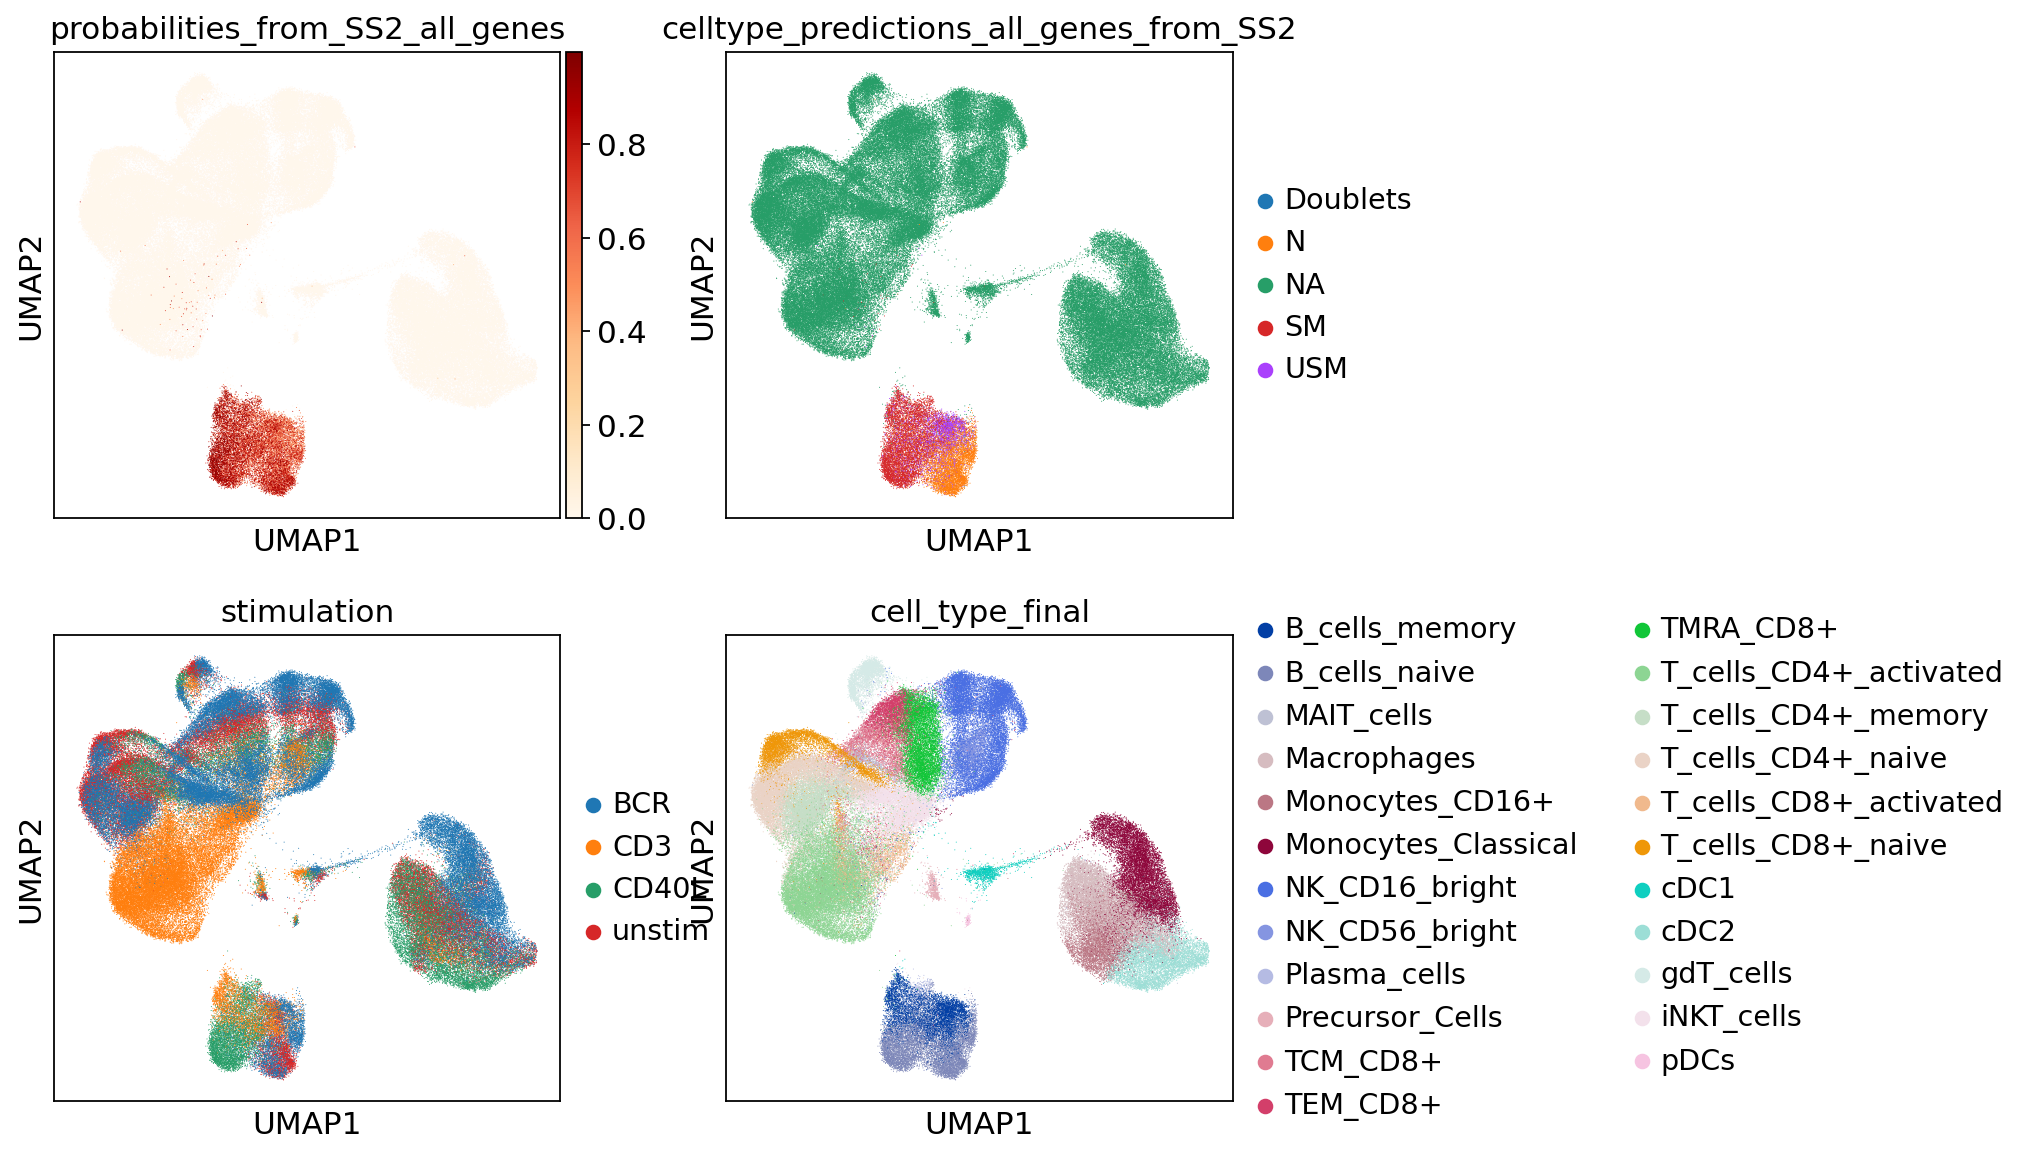

In [156]:
sc.pl.umap(adata_hvg, color = [#'probabilities_GC_hvgs', 'GC_celltype_predictions_hvgs',
                               'probabilities_from_SS2_all_genes', 'celltype_predictions_all_genes_from_SS2',
                              'stimulation', 'cell_type_final'],
           ncols=2,
           cmap='OrRd')

### this makes sense because in the SS2 dataset there were only non-activated B cells, so here it predicts SM lables in the activated B cell compartment, although correctly predicts the B cells in unstim + BCR compartment

In [157]:
table_predictions_from_SS2 = adata_hvg.obs.loc[:, ['celltype_predictions_all_genes_from_SS2', 'probabilities_from_SS2_all_genes']]

In [158]:
table_predictions_from_SS2.head()

,celltype_predictions_all_genes_from_SS2,probabilities_from_SS2_all_genes
AAACCTGAGAATGTGT-1,NA,0.0
AAACCTGAGACTAAGT-1,NA,0.0
AAACCTGAGCCGCCTA-1,NA,0.0
AAACCTGAGCGCCTCA-1,NA,0.0
AAACCTGAGGATGTAT-1,NA,0.0


In [159]:
table_predictions_from_SS2.shape

(145823, 2)

In [160]:
table_predictions_from_SS2.to_csv(save_path + 'table_predictions_N_USM_SM_B_cells_from_SS2_GEX_and_SoupX_denoised_protein_all_samples_20210113.csv')

# 2. Predicting Naive/Memory B cells from (b) [covid dataset](https://www.covid19cellatlas.org/index.patient.html) (Immunodeficiency PBMCs)

In [9]:
# id for immunodeficiency
adata_covid_id = sc.read('./immunodeficiency_PMBCs.h5ad')

In [10]:
adata_covid_id

AnnData object with n_obs × n_vars = 240627 × 33759
    obs: 'PreCondition', 'Hospitalized', 'Disease_classification', 'Deconvolved_samples', 'MT_fraction', 'log1p_total_counts', 'log2p1_nCiteseq_count', 'n_genes_by_counts', 'nCiteseq_features', 'CellType', 'Lab number', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'Cell sorting'
    var: 'gene_ids', 'feature_types', 'RBC_0', 'RBC_1', 'RBC_2', 'RBC_3', 'RBC_4', 'RBC_5', 'RBC_6', 'RBC_7', 'RBC_8', 'RBC_filtered'
    uns: '28-day death_colors', 'Admitted to hospital_colors', 'BLD_scmap_colors', 'CellType_colors', 'Pre-existing diabetes_colors', 'Pre-exis

In [11]:
# here the values are log2(raw_count + 1), using these
adata_covid_id.X

<240627x33759 sparse matrix of type '<class 'numpy.float64'>'
	with 458138140 stored elements in Compressed Sparse Column format>

In [13]:
np.unique(adata_covid_id.obs['CellType'])

array(['Activated monocytes', 'Bcells memory', 'Bcells naive',
       'Classical monocytes', 'Cycling Lymphocytes', 'Erythrocytes',
       'Gamma-delta', 'IFN Lymphocytes', 'Intermediate monocytes',
       'Low qc', 'Low qc monocytes', 'NK cytokine secretion',
       'NK cytolitic', 'Non-classical monocytes', 'Plasma Bcells',
       'Platets', 'Progenitors', 'Tcells CD4', 'Tcells CD8',
       'Tcells CD8 IL10', 'Tcells memory CD4', 'Tcells memory CD8',
       'Tcells naive', 'Treg', 'cDC1', 'cDC2', 'cell doublet',
       'filtered cells', 'pDC'], dtype=object)

In [14]:
# subsetting to only B cell clusters
adata_covid_id = adata_covid_id[adata_covid_id.obs['CellType'].isin(['Bcells memory', 'Bcells naive'])]

In [15]:
# scaling
sc.pp.scale(adata_covid_id, max_value=10)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [16]:
adata_hvg_B_cells = adata_hvg[adata_hvg.obs['cell_type_final'].isin(['B_cells_memory', 'B_cells_naive', 'Plasma_cells'])].copy()

In [17]:
adata_B_full = anndata.AnnData(X = adata_hvg_B_cells.raw.X,
                              obs = adata_hvg_B_cells.obs,
                              var = adata_hvg_B_cells.raw.var,
                              obsm = adata_hvg_B_cells.obsm,
                              varm = adata_hvg_B_cells.raw.varm)

# scaling
sc.pp.scale(adata_B_full, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [18]:
# full (all genes) versions of the annotated object and test object
# here both the datasets are normalised, log transformed and scaled
adata_train = adata_covid_id.copy()

adata_test = adata_B_full.copy()

In [19]:
adata_test

AnnData object with n_obs × n_vars = 14862 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'f

In [20]:
adata_train

AnnData object with n_obs × n_vars = 6927 × 33759
    obs: 'PreCondition', 'Hospitalized', 'Disease_classification', 'Deconvolved_samples', 'MT_fraction', 'log1p_total_counts', 'log2p1_nCiteseq_count', 'n_genes_by_counts', 'nCiteseq_features', 'CellType', 'Lab number', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'Cell sorting'
    var: 'gene_ids', 'feature_types', 'RBC_0', 'RBC_1', 'RBC_2', 'RBC_3', 'RBC_4', 'RBC_5', 'RBC_6', 'RBC_7', 'RBC_8', 'RBC_filtered', 'mean', 'std'
    uns: '28-day death_colors', 'Admitted to hospital_colors', 'BLD_scmap_colors', 'CellType_colors', 'Pre-existing diabetes_color

### Subsetting both datasets' copies to common genes only

I will train logreg on the subsetted data and tranfer the annotation onto the corresponding subsetted new data and then transfer that onto the full (with all genes) new dataset

In [21]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between previous training and test data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

17062 genes are shared between previous training and test data 
 33759 genes in training data 
 22144 genes in test joint data 



In [22]:
adata_train.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'ab_CD101(BB27)', 'ab_CD360(IL-21R)', 'ab_CD88(C5aR)', 'ab_HLA-F',
       'ab_NLRP2', 'ab_Podocalyxin', 'ab_CD224', 'ab_anti-c-Met',
       'ab_CD258(LIGHT)', 'ab_DR3(TRAMP)'],
      dtype='object', length=33759)

Going to copy a joint dataset with only common genes, but then transfer annotation from logreg onto the full dataset

In [23]:
adata_train_copy = adata_train[:,common_genes]

In [24]:
adata_train_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT', 'A4GNT',
       'AAAS', 'AACS', 'AADAT',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=17062)

In [25]:
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT', 'A4GNT',
       'AAAS', 'AACS', 'AADAT',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=17062)

In [26]:
# checking gene correspondence!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [27]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 6927 × 17062
    obs: 'PreCondition', 'Hospitalized', 'Disease_classification', 'Deconvolved_samples', 'MT_fraction', 'log1p_total_counts', 'log2p1_nCiteseq_count', 'n_genes_by_counts', 'nCiteseq_features', 'CellType', 'Lab number', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'Cell sorting'
    var: 'gene_ids', 'feature_types', 'RBC_0', 'RBC_1', 'RBC_2', 'RBC_3', 'RBC_4', 'RBC_5', 'RBC_6', 'RBC_7', 'RBC_8', 'RBC_filtered', 'mean', 'std'
    uns: '28-day death_colors', 'Admitted to hospital_colors', 'BLD_scmap_colors', 'CellType_colors', 'Pre-existing diabet

In [28]:
np.unique(adata_train_copy.obs['CellType'],return_counts=True)

(array(['Bcells memory', 'Bcells naive'], dtype=object), array([1574, 5353]))

# Training a logistic regression model on previously annotated SS2 data

In [29]:
adata_train_copy.obs['CellType'].head()

I-O-1_13_T_AAACGGGAGGTAGCCA-1-0    Bcells memory
I-O-1_13_T_AAAGATGTCAGGCGAA-1-0     Bcells naive
I-O-1_13_T_AAAGCAACAGACAGGT-1-0     Bcells naive
I-O-1_13_T_AAAGCAATCTCTGTCG-1-0     Bcells naive
I-O-1_13_T_AACCATGAGTCGTTTG-1-0    Bcells memory
Name: CellType, dtype: category
Categories (2, object): [Bcells naive < Bcells memory]

In [30]:
celltypes_train = adata_train_copy.obs['CellType']

In [31]:
adata_train_copy.X.shape

(6927, 17062)

Using ONLY COMMON GENES

In [32]:
%%time
# training a logistic regression model
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(adata_train_copy.X, celltypes_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 1min 22s, sys: 2min 5s, total: 3min 28s
Wall time: 45.6 s


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [33]:
# already done
# Saving model based on all genes
pkl_filename = "logreg_from_covid_all_genes_20210113.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr, file)

In [34]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 6927 × 17062
    obs: 'PreCondition', 'Hospitalized', 'Disease_classification', 'Deconvolved_samples', 'MT_fraction', 'log1p_total_counts', 'log2p1_nCiteseq_count', 'n_genes_by_counts', 'nCiteseq_features', 'CellType', 'Lab number', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'Cell sorting'
    var: 'gene_ids', 'feature_types', 'RBC_0', 'RBC_1', 'RBC_2', 'RBC_3', 'RBC_4', 'RBC_5', 'RBC_6', 'RBC_7', 'RBC_8', 'RBC_filtered', 'mean', 'std'
    uns: '28-day death_colors', 'Admitted to hospital_colors', 'BLD_scmap_colors', 'CellType_colors', 'Pre-existing diabet

In [35]:
adata_test_copy

View of AnnData object with n_obs × n_vars = 14862 × 17062
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_id

In [36]:
logisticRegr

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [37]:
%%time
predictions = logisticRegr.predict(adata_test_copy.X)
adata_test_copy.obs['celltype_predictions_all_genes_from_covid'] = predictions

Trying to set attribute `.obs` of view, copying.


CPU times: user 12.7 s, sys: 4.56 s, total: 17.3 s
Wall time: 15.6 s


In [38]:
%%time
# probabilities
probabilities = logisticRegr.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['celltype_predictions_all_genes_from_covid']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])


CPU times: user 1.3 s, sys: 1.46 s, total: 2.76 s
Wall time: 877 ms


In [39]:
# need to only assign predictions and probabilities to B cell clusters
list(adata_test_copy.obs.index) == list(adata_hvg.obs.index)

False

In [40]:
adata_test_copy.obs['probabilities_from_covid_all_genes'] = probs_adata

In [41]:
def add_predictions_and_probs(barcode, 
                              col # either celltype_predictions_all_genes_from_SS2 or probabilities_from_SS2_all_genes
                             ):
    
    barcode_is_B_cell = barcode in adata_test_copy.obs_names
    
    if barcode_is_B_cell:
        value = adata_test_copy.obs.loc[barcode, col]
        return(value)
    else:
        if col == 'probabilities_from_covid_all_genes':
            return(0)
        elif col == 'celltype_predictions_all_genes_from_covid':
            return('NA')
        

In [42]:
adata_hvg.obs['barcode'] = adata_hvg.obs.index

In [43]:
for column in ['celltype_predictions_all_genes_from_covid','probabilities_from_covid_all_genes']:
    print(column)
    adata_hvg.obs[column] = adata_hvg.obs['barcode'].apply(lambda x: add_predictions_and_probs(x, column))

celltype_predictions_all_genes_from_covid
probabilities_from_covid_all_genes


... storing 'cell_type_final' as categorical
... storing 'celltype_predictions_all_genes_from_covid' as categorical


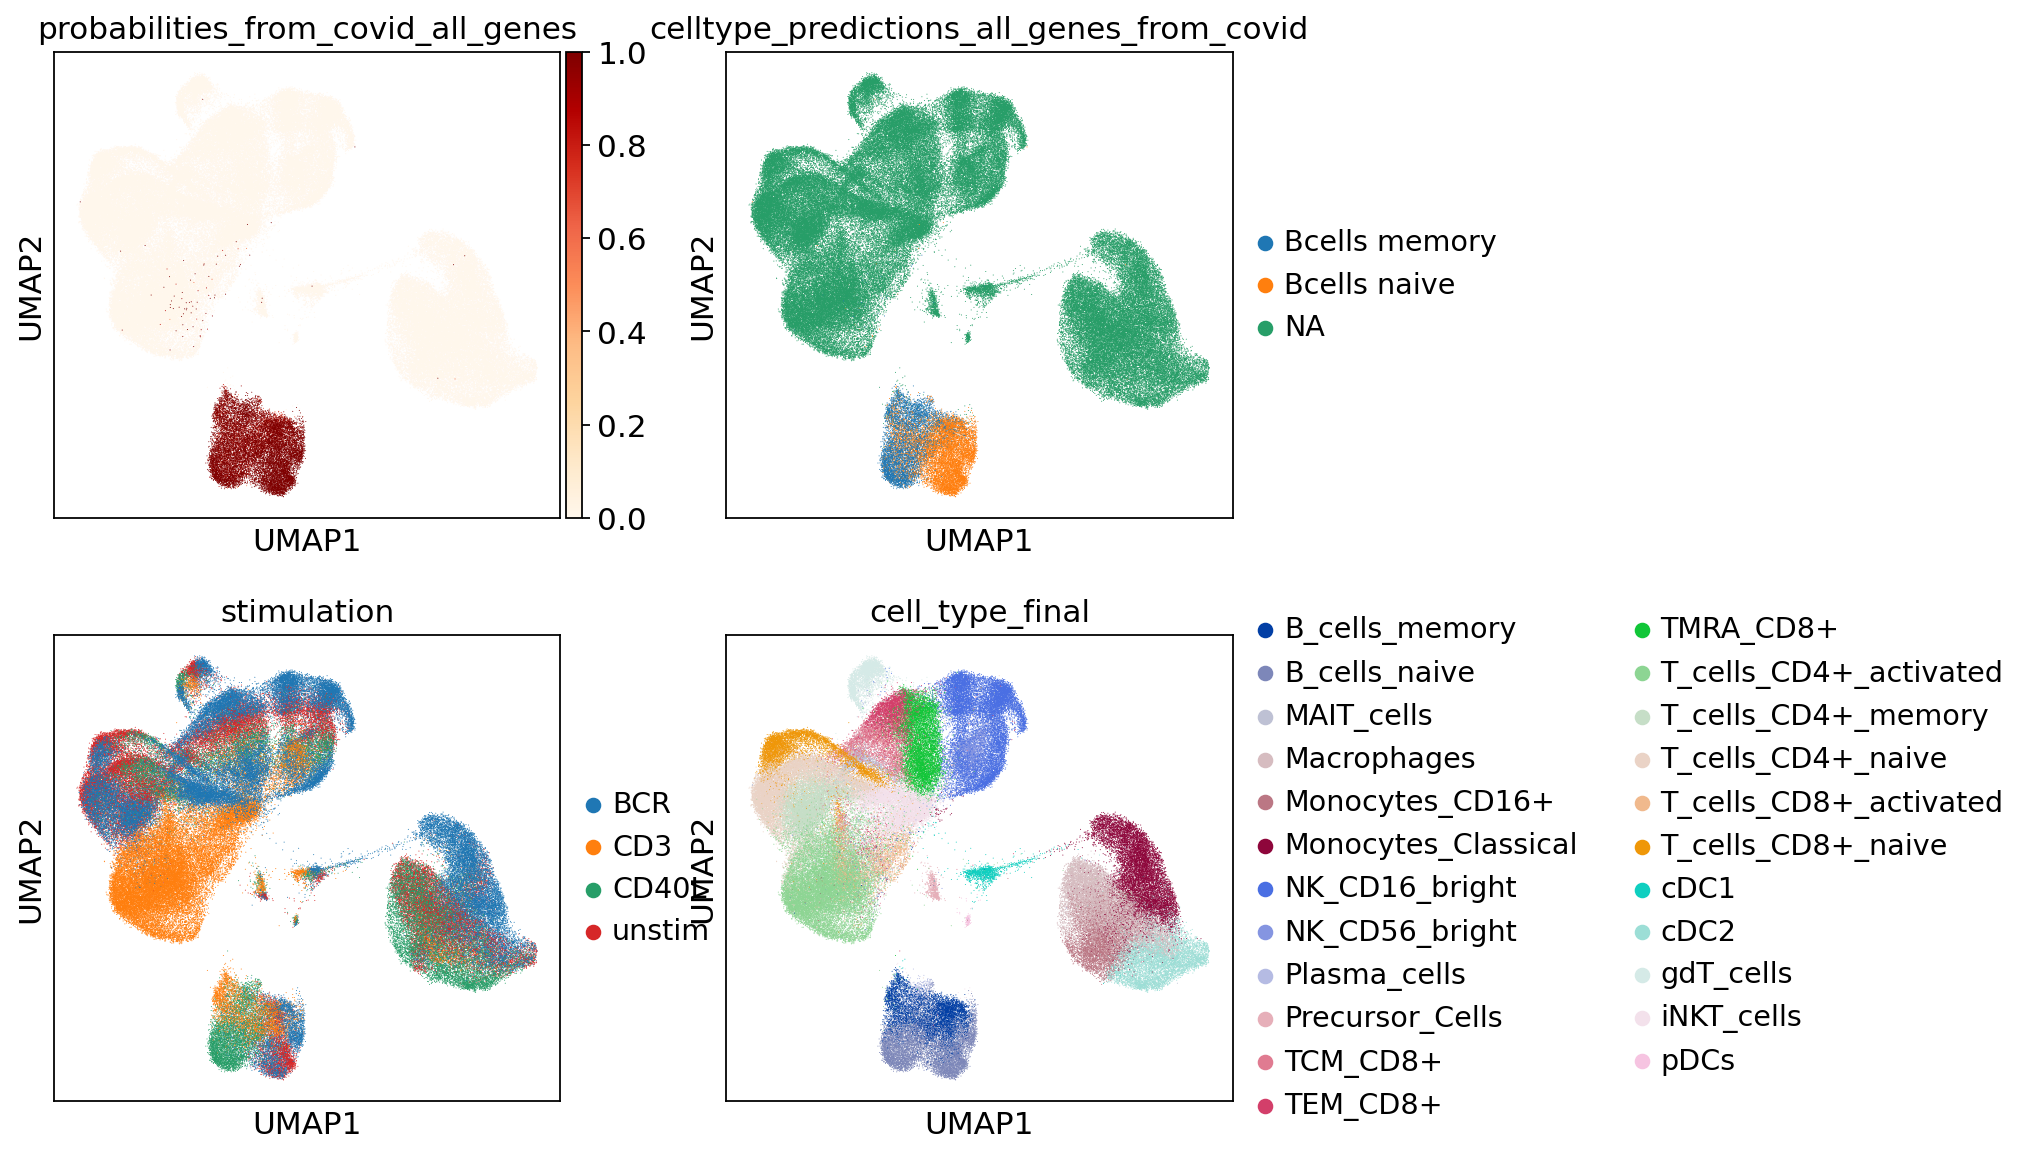

In [44]:
sc.pl.umap(adata_hvg, color = [#'probabilities_GC_hvgs', 'GC_celltype_predictions_hvgs',
                               'probabilities_from_covid_all_genes', 'celltype_predictions_all_genes_from_covid',
                              'stimulation', 'cell_type_final'],
           ncols=2,
           cmap='OrRd')

### this makes sense because in the covid dataset there were only non-activated B cells, so here it predicts B memory lables in the activated B cell compartment, although correctly predicts the B cells in unstim + BCR compartment

In [45]:
table_predictions_from_covid = adata_hvg.obs.loc[:, ['celltype_predictions_all_genes_from_covid', 'probabilities_from_covid_all_genes']]

In [46]:
table_predictions_from_covid.head()

,celltype_predictions_all_genes_from_covid,probabilities_from_covid_all_genes
AAACCTGAGAATGTGT-1,NA,0.0
AAACCTGAGACTAAGT-1,NA,0.0
AAACCTGAGCCGCCTA-1,NA,0.0
AAACCTGAGCGCCTCA-1,NA,0.0
AAACCTGAGGATGTAT-1,NA,0.0


In [47]:
table_predictions_from_covid.shape

(145823, 2)

In [48]:
table_predictions_from_covid.to_csv(save_path + 'table_predictions_naive_memory_B_cells_from_covid_GEX_and_SoupX_denoised_protein_all_samples_20210113.csv')